In [1]:
%matplotlib inline
# autoreload
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import numpy as np
from sklearn.datasets import make_swiss_roll
import torch
import matplotlib.pyplot as plt
import tqdm

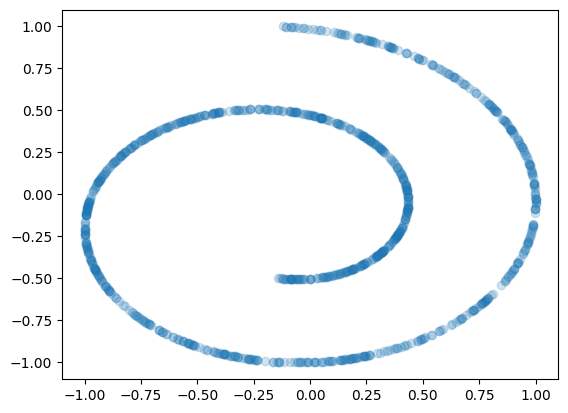

In [3]:
data = make_swiss_roll(1000, noise=0)[0][:, [0, 2]]
#data -= data.mean(0)
#data /= data.std(0)
# scale to -1, 1
data = (data - data.min(0)) / (data.max(0) - data.min(0))
data = data * 2 - 1
plt.scatter(*data.T, alpha=0.2)

In [ ]:
# Outstanding questions:
"""
1. What if we sampled t from a -->continuous<-- (uniform) distribution?
2. Predict noise increment?
"""

class DM(torch.nn.Module):
    def __init__(self, n_features, n_hidden, T=100, s=1, lr=1e-3):
        super().__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.T = T
        self.s = s
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_features+1, n_hidden*10),
            torch.nn.GELU(),
            torch.nn.Linear(n_hidden*10, n_hidden*20),
            torch.nn.GELU(),
            torch.nn.Linear(n_hidden*20, n_hidden*40),
            torch.nn.GELU(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(n_hidden*40, n_hidden*20),
            torch.nn.GELU(),
            torch.nn.Linear(n_hidden*20, n_hidden*10),
            torch.nn.GELU(),
            torch.nn.Linear(n_hidden*10, n_features),
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x, t=None):
        # sample t uniform on [1, T]
        t = torch.randint(1, self.T+1, (x.shape[0], 1), device=x.device) if t is None else t
        noise = torch.sqrt(1 - self.alpha_bar(t)) * torch.randn_like(x)
        noisy_x = torch.sqrt(self.alpha_bar(t)) * x + noise
        return noisy_x, noise, t

    def forward_old(self, x, t=None):
        # sample t uniform on [1, T]
        t = torch.randint(1, self.T+1, (x.shape[0], 1), device=x.device) if t is None else t
        noise = torch.randn_like(x)
        noisy_x = torch.sqrt(self.alpha_bar(t)) * x + torch.sqrt(1 - self.alpha_bar(t)) * noise
        return noisy_x, noise, t

    def backward(self, x, t):
        input = torch.cat([x, t/self.T], dim=1)
        return self.decoder(self.encoder(input))
    
    def sample(self, n_samples, t_stop=0):
        x_t = torch.randn(n_samples, self.n_features)
        for t in range(self.T, t_stop, -1): # [T, T-1, ..., 1]
            noise = torch.randn_like(x_t)
            ts = torch.ones(n_samples, 1) * t
            noise_hat = self.backward(x_t, ts)
            alpha = self.alpha(ts)
            langevin_noise = self.sigma(ts) * noise if t > 1 else 0
            x_t = 1/torch.sqrt(alpha) * \
                (x_t - (1-alpha)/torch.sqrt(1-self.alpha_bar(ts)) * noise_hat) + langevin_noise
        return x_t
    
    def beta(self, t, start=0.001, end=0.005):
        return start + (end - start) * (t / self.T)
    
    def sigma(self, t):
        return torch.sqrt(self.beta(t))

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        alpha_bars = []
        for i in range(t.shape[0]):
            current_t = t[i].item() if len(t.shape) == 1 else t[i, 0].item()  # Handle 1D or 2D case
            alpha_bars.append(torch.prod(self.alpha(torch.arange(1, current_t+1)))) # [1, 2, ..., t]
        return torch.stack(alpha_bars)[:,None]
    
    def loss_fn(self, x):
        noisy_x, noise, t = self.forward(x)
        noise_hat = self.backward(noisy_x, t)
        se = torch.sum((noise - noise_hat)**2, dim=-1)
        return se, t

    def train_step(self, loss):
        loss = loss.mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [5]:
diffusion_model = DM(2, 1, T=1000, s=50, lr=1e-3)
batch_size = 64
loss_history = []
ts = []

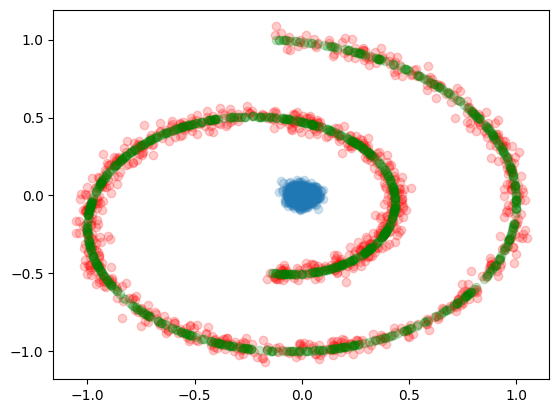

In [24]:
x, e, t = diffusion_model(torch.tensor(data),t=torch.ones(data.shape[0],1)*1)
plt.scatter(*e.detach().numpy().T, alpha=0.2)
plt.scatter(*x.detach().numpy().T, alpha=0.2, c='r')
plt.scatter(*data.T, alpha=0.2, c='g')

(1000, 1, 1)


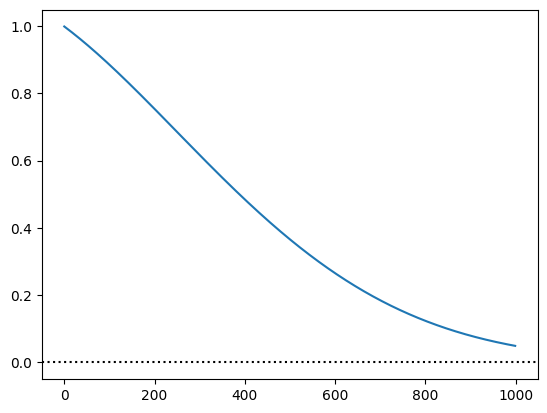

In [7]:
tmp = np.array(list(map(diffusion_model.alpha_bar, torch.arange(1, diffusion_model.T+1)[:,None])))
print(tmp.shape)
plt.plot(tmp.flatten())
plt.axhline(0, 0, 100, ls=':', c='k')

In [8]:
#diffusion_model.optimizer.param_groups[0]['lr'] = 1e-4
ntrain_steps = 60000
loss_history = list(loss_history)
ts = list(ts)
for i in tqdm.trange(len(loss_history), ntrain_steps):
    random_idxs = np.random.choice(np.arange(len(data)), batch_size, replace=False)
    data_batch = torch.tensor(data[random_idxs], dtype=torch.float32)
    loss, t = diffusion_model.loss_fn(data_batch)
    diffusion_model.train_step(loss)
    loss_history.append(loss.detach().numpy())
    ts.append(t)
ts = np.array(ts)
loss_history = np.array(loss_history)

100%|██████████| 60000/60000 [01:44<00:00, 573.75it/s]


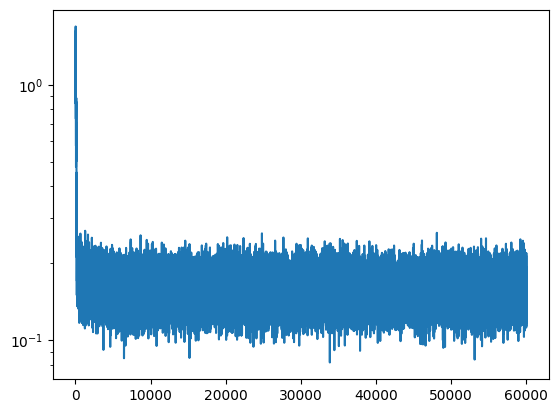

In [9]:
ts = np.array(ts)
loss_history = np.array(loss_history)
plt.semilogy(loss_history.mean(1))

[[<matplotlib.lines.Line2D at 0x322b1f700>],

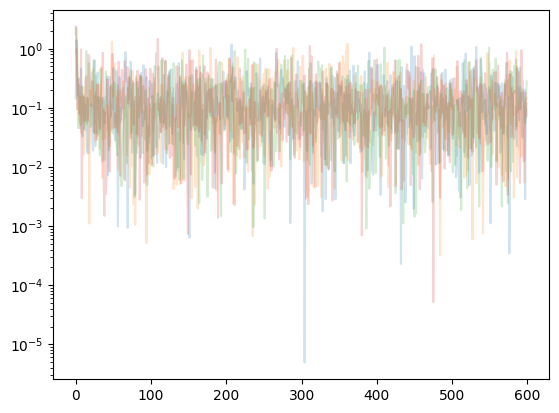

In [10]:
[plt.semilogy(loss_history[::100,i], alpha=0.2) for i in range(0, loss_history.shape[1], 20)]

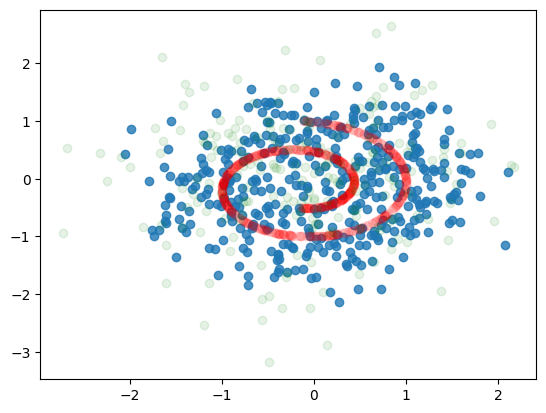

In [11]:
x_hat = diffusion_model.sample(400, t_stop=0).detach().numpy()
plt.scatter(*x_hat.T, alpha=0.8)
plt.scatter(*data.T, alpha=0.05, c='r')
plt.scatter(np.random.randn(200), np.random.randn(200), alpha=0.1, c='g')
#plt.xlim(-1,1)
#plt.ylim(-1,1)

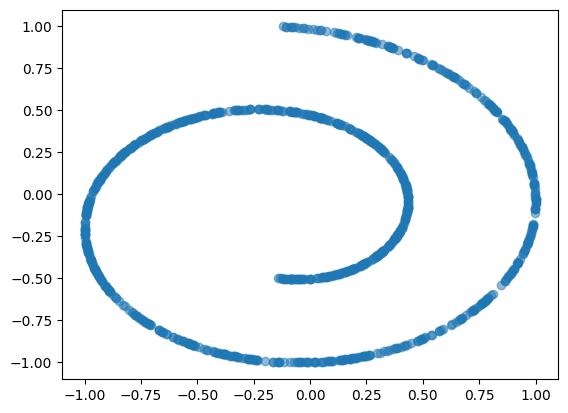

In [12]:
from mplextensions import time_scatter
fig, ax = plt.subplots()
ax.scatter(*data.T, alpha=0.5)
x_hats = []
for t in [1000, 500, 250, 100, 50, 25, 10, 5, 1]:
    x_hat = diffusion_model.sample(200, t_stop=t).detach().numpy()
    x_hats.append(x_hat)
x_hats = np.array(x_hats)

In [14]:
fig,ax = plt.subplots()
plt.scatter(*data.T, alpha=0.5)
html = time_scatter(x_hats[...,0].T, x_hats[...,1].T, fps=24, fig=fig, ax=ax, color='r')
#i=3
#html = time_scatter(x_hats[:,i:i+1,0].T, x_hats[:,i:i+1,1].T, fps=24, fig=fig, ax=ax, color='r')
html